## GAT IMPLEMENTATION

In [1]:
TOTAL_CLIENTS = 610
TRAIN_CLIENTS_RATIO = 0.7
VALIDATION_RATIO = 0.2
ROUND_CLIENTS = 128

MINI_BATCH_SIZE = 32
LR = 0.01
INPUT_CHANNELS = 256
HIDDEN_CHANNELS = 256
USER_EMBEDDING_SIZE = 1 

ROUNDS = 25
EPOCHS = 3


INCLUDE_NEIGHBORS = True
NEIGHBORS_THRESHOLD = 5

# 100k Ratings Dataset
RATINGS_DATAFILE = 'ml-latest-small/ratings.csv'
MOVIES_INFO_DATAFILE = 'ml-latest-small/movies.csv'

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, GATConv
from torch.autograd import Variable
from torch_geometric.data import Data

import numpy as np
import pandas as pd
import random

In [3]:
class GAT(torch.nn.Module):
    
    def __init__(self):
        super(GAT, self).__init__()
        self.hidden_channels = INPUT_CHANNELS
        self.input_channels = HIDDEN_CHANNELS
        self.headsv1 = 1
        self.headsv2 = 1
 
        self.conv1 = GATConv(in_channels=self.input_channels, out_channels=self.hidden_channels,
                           heads=self.headsv1, dropout=0.2)
        ####
#         self.conv2 = GATv2Conv(in_channels=self.hidden_channels*self.headsv1, out_channels=self.hidden_channels,
#                              heads=self.headsv2, dropout=0.2)
        ####
        
    def forward(self, data, item_len):
        x, edge_index = data.x, data.edge_index  
        x_in = Variable(x, requires_grad=True)
        x = F.dropout(x_in, p=0.2, training=self.training) 
        x = self.conv1(x, edge_index)                   
        x = F.elu(x)
        
        ###
#         x = F.dropout(x, p=0.2, training=self.training)
#         x = self.conv2(x, edge_index)
#         x = F.elu(x)
        ###
        
        y = x[0,:] * x[1:item_len,:]
        y = torch.sum(y, dim=1, dtype=float)
        y = F.elu(y)
        y.retain_grad()
        return x_in, y
    
    

## Federated Pipeline

In [4]:
class FederatedNetwork:
    
    def __init__(self, initial_weights, device):
        self.model = None
        self.optimizer = None
        self.criterion = None
        self.device = device
#         self.preivous_weights=None
        self.initialize_model(initial_weights)
        
    def initialize_model(self, initial_weights):
        self.model = GAT().to(self.device)
        if initial_weights != None:
            self.model.load_state_dict(initial_weights)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=LR, weight_decay=5e-4)
#         self.optimizer = torch.optim.SGD(self.model.parameters(), lr=LR, momentum=0.9)

        self.criterion = nn.MSELoss()  #Square Root taken later in training to make RMSE
        

In [5]:
class Client(FederatedNetwork):
   
    def __init__(self, client_id, items_rated_df, all_items_embeddings_df, initial_weights, device):
        super().__init__(initial_weights, device)
        self.id = client_id
        
        self.items_rated_df = items_rated_df
        self.all_items_embeddings_df = all_items_embeddings_df
        self.rated_items_embeddings_df = None
        self.user_embeddings = None
        
        self.train_idx = None
        self.val_idx = None
        
        self.train_graph = None
        self.train_y = None
        self.val_graph = None
        self.val_y = None
        
        self.train_x_df = None
        self.valid_x_df = None
        self.train_y_df = None
        self.valid_y_df = None
        
        
        self.neighbors = None
        
        self.initialize_client()
        
        
    def find_splits(self):
        data_len = len(self.items_rated_df)
        data_idx = random.sample(range(0, data_len), 
                                 data_len)
        train_idx = data_idx[round(data_len*VALIDATION_RATIO):]
        valid_idx = data_idx[:round(data_len*VALIDATION_RATIO)]
        

        return train_idx, valid_idx
        
        
    def initialize_client(self):
        self.user_embeddings = torch.nn.init.xavier_uniform_(torch.empty(USER_EMBEDDING_SIZE, 256))
        self.train_idx, self.valid_idx = self.find_splits()
        
        self.split_data_and_create_graphs()
        
    
    def split_data_and_create_graphs(self):
        
        self.rated_items_embeddings_df = self.all_items_embeddings_df[
            self.all_items_embeddings_df['movieId'].isin(self.items_rated_df["movieId"])]
        
        self.train_x_df = self.rated_items_embeddings_df.iloc[self.train_idx]
#         if self.valid_x_df == None:
        self.valid_x_df = self.rated_items_embeddings_df.iloc[self.valid_idx]
        self.train_y_df = self.items_rated_df.iloc[self.train_idx]
        self.valid_y_df = self.items_rated_df.iloc[self.valid_idx]
        
        self.create_graph_data()
    
        
    def create_graph_data(self):
        x, y, edge_index = self.convert_df_to_graph(self.train_y_df, self.train_x_df)
        self.train_graph = Data(x=x, edge_index=edge_index).to(self.device)
        self.train_y = y
        
        x, y, edge_index = self.convert_df_to_graph(self.valid_y_df, self.valid_x_df)
        self.val_graph = Data(x=x, edge_index=edge_index).to(self.device)
        self.val_y = y
        
        
    def convert_df_to_graph(self, items_rated_df, rated_items_embeddings_df):
        
        edges_start = [0]*(len(items_rated_df)) + [i for i in range(1, len(items_rated_df)+1)]
        edges_end = [i for i in range(1, len(items_rated_df)+1)]+[0]*(len(items_rated_df)) 
        
        if self.neighbors != None and INCLUDE_NEIGHBORS:
            edges_start += [0]*(len(self.neighbors)) + [i for i in range(len(items_rated_df)+1, 
                                                                        len(items_rated_df)+1+len(self.neighbors))]
            edges_end += [i for i in range(len(items_rated_df)+1,
                                            len(items_rated_df)+1+len(self.neighbors))] + [0]*(len(self.neighbors))
        
        edge_index = torch.tensor([edges_start, edges_end], dtype=torch.long)
        
        x = [self.user_embeddings.numpy()[0], ] #User Embeddings
        embeddings_col = rated_items_embeddings_df['embeddings'].values
        x += [val for val in embeddings_col]   #Item Embeddings

        if self.neighbors != None and INCLUDE_NEIGHBORS:
            x += self.neighbors
            
        x = torch.tensor(np.array(x), dtype=torch.float) #Converting embeddings array into tensor
        
        y = torch.tensor(items_rated_df['rating'].values)
        
        return x, y, edge_index
    
    
    def update_to_global_weights(self, weights):
        self.model.load_state_dict(weights)
    
    
    def train_model(self, lr=LR):
        self.model.train()
        for epoch in range(EPOCHS):
            self.optimizer.zero_grad()
            x, out = self.model(self.train_graph, len(self.train_x_df)+1)
            loss = torch.sqrt(self.criterion(out, self.train_y))            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.1)
            self.optimizer.step()  
            self.train_graph.x -= lr*x.grad
            
        self.update_df_embeddings_from_train_graph()
        
        return loss
    
    def get_item_ids(self):
        return self.rated_items_embeddings_df['movieId'].values
    
    
    def update_df_embeddings_from_train_graph(self):
        self.user_embedding = self.train_graph.x[0]
        self.val_graph.x[0] = self.train_graph.x[0]
        for i in range(1, len(self.train_x_df)):
            index = self.all_items_embeddings_df.index[
                self.all_items_embeddings_df['movieId'] == self.rated_items_embeddings_df.iloc[i-1]['movieId']]
            self.rated_items_embeddings_df.iat[i-1, 1] =  self.train_graph.x[i]
            self.all_items_embeddings_df.iat[index[0], 1] =  self.train_graph.x[i].numpy()
            
            
    def get_item_embeddings(self):
        return self.all_items_embeddings_df
    
        
    def item_count(self):
        return len(self.rated_items_embeddings_df)
    
    
    def update_to_global_embeddings(self, items_embeddings):
        self.all_items_embeddings_df = items_embeddings
        self.split_data_and_create_graphs()
    
    
    def evaluate_model(self, model=None):
        data = self.val_graph

        if model == None:
            model = self.model

        model.eval()
        
        _, pred = model(data, len(self.valid_x_df)+1)
        pred = torch.round(2*pred.data)/2
        
        loss = torch.sqrt(self.criterion(pred, self.val_y))  

        correct = float(pred.eq(self.val_y).sum().item())
        acc = correct / len(self.val_y)

        return acc, loss
    
    def include_neighbors(self, neighbors_embeddings):
        self.neighbors = neighbors_embeddings
        

In [6]:
class Initializer:

    def __init__(self, device, initial_weights):
        
        #2-col df_items_embeddings with movieId and embeddings
        self.items_embeddings_df = None
        
        #all columns from ratings.csv
        self.items_ratings_df = None
        
        #all columns from movies.csv file
        self.items_info_df = None        
        self.clients = None

        self.train_clients_idx = None
        self.test_clients_idx = None
        self.initial_weights = initial_weights
        
        self.device = device
        self.generate_items_embeddings()
        self.initialize_clients()
        
        self.client_user_embeddings = None

    def initialize_clients(self):
        self.items_ratings_df = pd.read_csv(RATINGS_DATAFILE)
        self.items_ratings_df.drop('timestamp', inplace=True, axis=1)
        
        # RANDOMLY SELECTING TEST/TRAIN CLIENTS
        clients_idx =  random.sample(range(1, TOTAL_CLIENTS+1), TOTAL_CLIENTS)
        split_index = round(TOTAL_CLIENTS*TRAIN_CLIENTS_RATIO)
        train_clients_idx = clients_idx[:split_index]
        test_clients_idx = clients_idx[split_index:]
        self.clients = [Client(client_id=user_idx, 
                              items_rated_df=self.items_ratings_df[self.items_ratings_df['userId'] == user_idx], 
                              all_items_embeddings_df = self.items_embeddings_df, 
                              initial_weights=self.initial_weights,
                              device = device) for user_idx in train_clients_idx]
                        
        return self.clients
    
        
    def generate_items_embeddings(self):
        self.items_info_df = pd.read_csv(MOVIES_INFO_DATAFILE)
        
        # Initialize weights with xavier uniform
        embeddings = torch.nn.init.xavier_uniform_(torch.empty(self.items_info_df.shape[0], 256))
        
        # Creating 1-col df for embeddings
        df = pd.DataFrame({"id": np.arange(1, embeddings.shape[0]+1)})
        df["embeddings"] = list(embeddings.numpy())
        
        # Creating 2-col df items_embeddings with movieId and embeddings
        self.items_embeddings_df = pd.concat([self.items_info_df['movieId'], df["embeddings"]], axis=1)
    
    def get_items_embeddings(self):
        return self.get_item_embeddings_df
    
    
    def include_neighbors_embeddings(self):
            
        neighbor_user_embeddings_dict = dict()
        for client_index1 in range(len(self.clients)):
            item_ids = self.clients[client_index1].get_item_ids()
            for client_index2 in range(client_index1+1, len(self.clients)):
                item_ids_2 = self.clients[client_index2].get_item_ids()
#                 print("Item Id 1: ", len(item_ids), "\nItem Id 2: ", len(item_ids_2))
                for item_id in item_ids:
                    if item_id in item_ids_2:
                        if client_index1 in neighbor_user_embeddings_dict:
                            neighbor_user_embeddings_dict[client_index1] += [self.clients[client_index2].user_embeddings.numpy()[0]]
                        else:
                            neighbor_user_embeddings_dict[client_index1] = [self.clients[client_index2].user_embeddings.numpy()[0]]
                        if client_index2 in neighbor_user_embeddings_dict:
                            neighbor_user_embeddings_dict[client_index2] += [self.clients[client_index1].user_embeddings.numpy()[0]]
                        else:
                            neighbor_user_embeddings_dict[client_index2] = [self.clients[client_index1].user_embeddings.numpy()[0]]
                        break
                    
        for client_id in neighbor_user_embeddings_dict:
            self.clients[client_id].include_neighbors(neighbor_user_embeddings_dict[client_id])
            

## Driver Code for Training and Evaluation

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
global_model = GAT().to(device)
initializer = Initializer(device=device, initial_weights=global_model.state_dict())
print(initializer.clients[0].train_graph)

Data(x=[21, 256], edge_index=[2, 40])


In [10]:

lost = []
train_lost=[]

for training_round in range(ROUNDS):
    total_items = 0
    weights = []
    embeddings = [] 
    items_rated = []
    losses = []
    
    if training_round == NEIGHBORS_THRESHOLD:
        initializer.include_neighbors_embeddings()
    
    selected_clients = random.sample(range(0, len(initializer.clients)), ROUND_CLIENTS)
    
    #TRAIN THE NETWORK
    for client_idx in selected_clients:
        losses.append(initializer.clients[client_idx].train_model())
        total_items += initializer.clients[client_idx].item_count()
        weights.append(initializer.clients[client_idx].model.state_dict())
        embeddings.append(initializer.clients[client_idx].get_item_embeddings())
        items_rated.append(initializer.clients[client_idx].item_count())
    
    
    #UPDATE GLOBAL MODEL

    #WEIGHTED AVERAGE: 
    new_parameters = global_model.state_dict()
    for key in new_parameters:
        new_parameters[key] = weights[0][key]
        for i in range(1, len(weights)):
            new_parameters[key] += weights[i][key]*(items_rated[i])
        new_parameters[key]/=float(total_items)
        

    global_model.load_state_dict(new_parameters)
    
    
    #UPDATE GLOBAL EMBEDDINGS    
    df = pd.concat(i for i in embeddings)
    global_embeddings = df.groupby(by="movieId", as_index=False).mean()
    global_embeddings.reset_index()

    
    # EVALUATE
    acc = 0
    l_acc = 0
    g_loss = 0
    l_loss = 0
    for client in initializer.clients:
        acc_temp, g_loss_temp = client.evaluate_model(global_model)
        l_acc_temp, l_loss_temp = client.evaluate_model()
        acc += acc_temp
        g_loss += g_loss_temp
        l_acc += l_acc_temp
        l_loss += l_loss_temp
    loss = 0
    for i in losses:
        loss += i
    loss/=ROUND_CLIENTS
    
    
    print("\n\nRound: ", training_round)
    print('Validation Accuracy [Global Model][All Clients]: {:.4f}'.format(acc/ROUND_CLIENTS))
    print('Validation Accuracy [Local Model][All Clients]:  {:.4f}'.format(l_acc/ROUND_CLIENTS))

    print('Training Loss [Local Model][Train Clients]: {:.4f}'.format(loss.item()))
    print('Validation Loss [Global Model][All Clients]: {:.4f}'.format(g_loss.item()/ROUND_CLIENTS))
#     print('Local Valid Loss: {:.4f}'.format(l_loss.item()/ROUND_CLIENTS))
    lost.append(g_loss.item()/ROUND_CLIENTS)
    train_lost.append(loss.item())

    
    # UPDATE LOCAL CLIENTS
    for client in initializer.clients:
        client.update_to_global_weights(global_model.state_dict())
        client.update_to_global_embeddings(global_embeddings)


[239, 259, 315, 50, 209, 313, 102, 126, 35, 81, 36, 9, 131, 128, 107, 394, 330, 395, 296, 234, 421, 19, 311, 214, 341, 82, 384, 337, 408, 155, 211, 297, 41, 153, 103, 183, 371, 402, 295, 420, 67, 188, 89, 326, 177, 276, 181, 379, 212, 154, 410, 338, 405, 271, 329, 202, 178, 72, 163, 286, 340, 84, 127, 291, 83, 316, 230, 364, 375, 110, 182, 158, 302, 170, 152, 196, 409, 307, 309, 23, 253, 290, 383, 220, 145, 356, 367, 388, 97, 195, 54, 269, 305, 4, 318, 95, 77, 381, 70, 160, 33, 328, 331, 223, 403, 17, 151, 399, 130, 18, 232, 414, 303, 172, 174, 20, 0, 43, 401, 390, 247, 278, 30, 40, 252, 319, 279, 422]


Round:  0
Validation Accuracy [Global Model][All Clients]: 0.3135
Validation Accuracy [Local Model][All Clients]:  0.4203
Training Loss [Local Model][Train Clients]: 1.0546
Validation Loss [Global Model][All Clients]: 3.5132
[191, 21, 410, 159, 218, 278, 214, 421, 414, 93, 268, 267, 180, 295, 416, 347, 76, 158, 150, 300, 388, 419, 38, 424, 51, 395, 238, 187, 41, 149, 50, 126, 258, 331,

KeyboardInterrupt: 

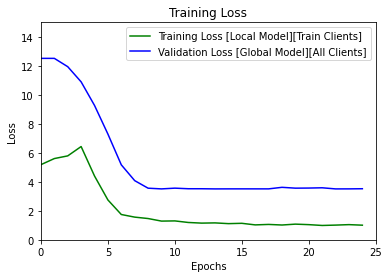

In [9]:
#PRINT LOSS GRAPH
import matplotlib.pyplot as plt
epochs = range(ROUNDS)
plt.plot(epochs, train_lost, 'g', label='Training Loss [Local Model][Train Clients]')
plt.plot(epochs, lost, 'b', label='Validation Loss [Global Model][All Clients]')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim([0, ROUNDS])
plt.ylim([0, 15])
plt.legend()
plt.show()

- During each epoch of the round, client should have created mini-bacthes of data on which model is trained (all mini-batches iterated in one epoch) [and they are averaged in the end of epoch and gradients of model are updated]



#### Self Notes:

- Xavier Uniform is used for weights initialization
- Node Ids are random i.e. same items don't have same id in different graphs
- How many times to include a neighbor (if there are more than one items in common)? currently: only once


#### FedGNN Paper Notes:

- In our experiments, we use graph attention network (GAT) [28] as the GNN model, 

- and use dot product to implement the rating predictor. 

- The user and item embeddings and their hidden representations learned by graph neural networks are 256-dim. 

- The gradient clipping threshold 𝛿 is set to 0.1

- The number of users used in each round of model training is 128, 

- and the total number of epoch is 3. 

- The ratio of dropout [25] is 0.2. 

- Its learning rate is 0.01. 

- The metric used in our experiments is rooted mean square error (RMSE), 

- FedAVG is used as aggregator

- The splits of datasets are the same as those used in [2], and these hyperparameters are selected according to the validation performance.

- Randomize clients subset in each round. 

- SGD is selected as the optimization algorithm (using Adam because this gets stuck)

- The round threshold 𝑇 is 2 for using neighboring users embeddings.


- **TODO** Create data mini-batches for training

- **TODO** the strength of Laplacian noise in the LDP module is set to 0.2 to achieve 1-differential privacy. 

- **TODO** The number of pseudo interacted items is set to 1,000.

- **TODO** We report the average RMSE scores over the 10 repetitions.

#### Learning on un trained client

- **TODO** Write routine to learn user embedding from item embeddings

#### Pseudo Interacted Items:

- Concretely, we sample 𝑀 items that the user has not interacted with5 , and randomly generate their gradients g𝑖 using a Gaussian distribution with the same mean and co-variance values with the real item embedding gradients. The real embedding gradients g𝑖𝑒 are combined with the pseudo item 𝑝 embedding gradients g𝑖